In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
gtzan = '/content/drive/MyDrive/MiniProject/GTZANOld'
genre_folders=os.listdir(gtzan)
print(genre_folders)
# make dict of key folder name and value list of files contained in it
genre_files={}
for genre in genre_folders:
  genre_files[genre]=os.listdir(os.path.join(gtzan,genre))
print(genre_files)

['pop', 'country', 'disco', 'metal', 'blues', 'reggae', 'rock', 'hiphop', 'classical', 'jazz']
{'pop': ['pop.00002.wav', 'pop.00001.wav', 'pop.00007.wav', 'pop.00004.wav', 'pop.00006.wav', 'pop.00005.wav', 'pop.00000.wav', 'pop.00008.wav', 'pop.00009.wav', 'pop.00003.wav', 'pop.00020.wav', 'pop.00013.wav', 'pop.00015.wav', 'pop.00021.wav', 'pop.00012.wav', 'pop.00011.wav', 'pop.00022.wav', 'pop.00017.wav', 'pop.00019.wav', 'pop.00010.wav', 'pop.00016.wav', 'pop.00014.wav', 'pop.00018.wav', 'pop.00026.wav', 'pop.00025.wav', 'pop.00036.wav', 'pop.00033.wav', 'pop.00024.wav', 'pop.00030.wav', 'pop.00023.wav', 'pop.00028.wav', 'pop.00031.wav', 'pop.00037.wav', 'pop.00029.wav', 'pop.00035.wav', 'pop.00034.wav', 'pop.00027.wav', 'pop.00032.wav', 'pop.00046.wav', 'pop.00044.wav', 'pop.00050.wav', 'pop.00042.wav', 'pop.00048.wav', 'pop.00049.wav', 'pop.00043.wav', 'pop.00041.wav', 'pop.00040.wav', 'pop.00047.wav', 'pop.00045.wav', 'pop.00038.wav', 'pop.00039.wav', 'pop.00051.wav', 'pop.00054.w

MFCC Feature extraction


In [20]:
import librosa
def extract_mfcc(file_path, max_len = 200):
    y, sr = librosa.load(file_path, sr=None)
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40)
    if mfcc.shape[1] < max_len:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

  # y,sr=librosa.load(file_path)
  # mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40)
  # return mfcc

In [21]:
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [22]:
from tqdm import tqdm
mfcc_X = []
mfcc_y = []

for genre, files in genre_files.items():
    for file in tqdm(files, desc=f"Processing {genre}"):
        mfcc = extract_mfcc(os.path.join(gtzan, genre, file))
        if mfcc is not None:
          mfcc_X.append(mfcc)
          mfcc_y.append(genre_folders.index(genre))



Processing jazz: 100%|██████████| 99/99 [00:37<00:00,  2.65it/s]


In [23]:
max_length = max([mfcc.shape[1] for mfcc in mfcc_X])

# Pad the sequences to have the same length
mfcc_X = np.array([np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant') for mfcc in mfcc_X])

# Convert y to a NumPy array
mfcc_y = np.array(mfcc_y)

# Add a channel dimension to X
mfcc_X = mfcc_X[..., np.newaxis]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.2, random_state=42)
# gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu = gpus[0]
# tf.config.experimental.set_memory_growth(gpu, True)

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# # Optimize the dataset
# batch_size = 32
# train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Define the CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, max_length, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
25/25 [==============================] - 13s 477ms/step - loss: 3.2690 - accuracy: 0.1915 - val_loss: 2.0436 - val_accuracy: 0.2400
Epoch 2/15
25/25 [==============================] - 8s 334ms/step - loss: 1.7560 - accuracy: 0.3317 - val_loss: 1.6241 - val_accuracy: 0.3850
Epoch 3/15
25/25 [==============================] - 11s 431ms/step - loss: 1.5542 - accuracy: 0.4355 - val_loss: 1.5641 - val_accuracy: 0.3850
Epoch 4/15
25/25 [==============================] - 10s 408ms/step - loss: 1.4612 - accuracy: 0.4606 - val_loss: 1.4870 - val_accuracy: 0.4800
Epoch 5/15
25/25 [==============================] - 9s 334ms/step - loss: 1.2231 - accuracy: 0.5444 - val_loss: 1.3030 - val_accuracy: 0.5200
Epoch 6/15
25/25 [==============================] - 10s 423ms/step - loss: 1.0097 - accuracy: 0.6471 - val_loss: 1.2856 - val_accuracy: 0.5700
Epoch 7/15
25/25 [==============================] - 13s 529ms/step - loss: 0.8535 - accuracy: 0.6934 - val_loss: 1.5003 - val_accuracy: 0.4950
E

In [26]:
model.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-15-old.h5')


In [27]:
loss, overall_accuracy = model.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

7/7 [==============================] - 1s 115ms/step - loss: 2.3341 - accuracy: 0.5050
Overall Test Accuracy: 50.50%


In [28]:
genre_accuracies = []
genre_names = []

genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")


7/7 [==============================] - 1s 71ms/step
Accuracy for Pop: 47.62%
Accuracy for Country: 50.00%
Accuracy for Disco: 29.17%
Accuracy for Metal: 81.82%
Accuracy for Blues: 40.00%
Accuracy for Reggae: 50.00%
Accuracy for Rock: 17.65%
Accuracy for Hiphop: 55.00%
Accuracy for Classical: 86.36%
Accuracy for Jazz: 36.84%


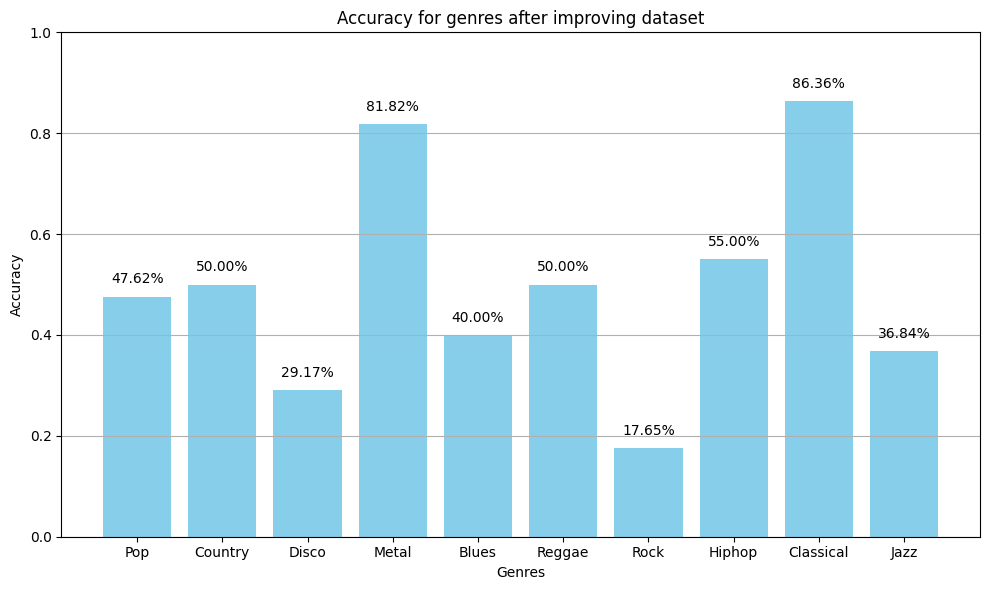

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('Accuracy for genres before improving dataset')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, max_length, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(genre_folders), activation='softmax')
])
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
25/25 [==============================] - 11s 386ms/step - loss: 4.0792 - accuracy: 0.1602 - val_loss: 2.0209 - val_accuracy: 0.2400
Epoch 2/20
25/25 [==============================] - 10s 386ms/step - loss: 1.8789 - accuracy: 0.3016 - val_loss: 1.6966 - val_accuracy: 0.3950
Epoch 3/20
25/25 [==============================] - 11s 436ms/step - loss: 1.5437 - accuracy: 0.4506 - val_loss: 1.6194 - val_accuracy: 0.4200
Epoch 4/20
25/25 [==============================] - 8s 333ms/step - loss: 1.3992 - accuracy: 0.4806 - val_loss: 1.4579 - val_accuracy: 0.4750
Epoch 5/20
25/25 [==============================] - 11s 433ms/step - loss: 1.1511 - accuracy: 0.5870 - val_loss: 1.4590 - val_accuracy: 0.5200
Epoch 6/20
25/25 [==============================] - 10s 419ms/step - loss: 1.0425 - accuracy: 0.6233 - val_loss: 1.4106 - val_accuracy: 0.5250
Epoch 7/20
25/25 [==============================] - 11s 433ms/step - loss: 0.9134 - accuracy: 0.6796 - val_loss: 1.6002 - val_accuracy: 0.4800


In [31]:
model2.save('/content/drive/MyDrive/MiniProject/Models/cnn-mpcc-20-old.h5')

In [32]:
loss, overall_accuracy = model2.evaluate(X_test, y_test)
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")
genre_accuracies = []
genre_names = []

genre_to_label = {genre: i for i, genre in enumerate(genre_folders)}
# X_train, X_test, y_train, y_test = train_test_split(mfcc_X, mfcc_y, test_size=0.3, random_state=50)
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

for genre in genre_folders:
    genre_index = genre_to_label[genre]
    genre_indices = np.where(y_true == genre_index)[0]
    if len(genre_indices) > 0:
        genre_accuracy = np.mean(y_pred_classes[genre_indices] == y_true[genre_indices])
        genre_accuracies.append(genre_accuracy)
        genre_names.append(genre.capitalize())
        print(f"Accuracy for {genre.capitalize()}: {genre_accuracy * 100:.2f}%")

7/7 [==============================] - 1s 73ms/step - loss: 2.8381 - accuracy: 0.5250
Overall Test Accuracy: 52.50%
7/7 [==============================] - 1s 74ms/step
Accuracy for Pop: 61.90%
Accuracy for Country: 33.33%
Accuracy for Disco: 45.83%
Accuracy for Metal: 86.36%
Accuracy for Blues: 46.67%
Accuracy for Reggae: 39.29%
Accuracy for Rock: 17.65%
Accuracy for Hiphop: 60.00%
Accuracy for Classical: 77.27%
Accuracy for Jazz: 42.11%


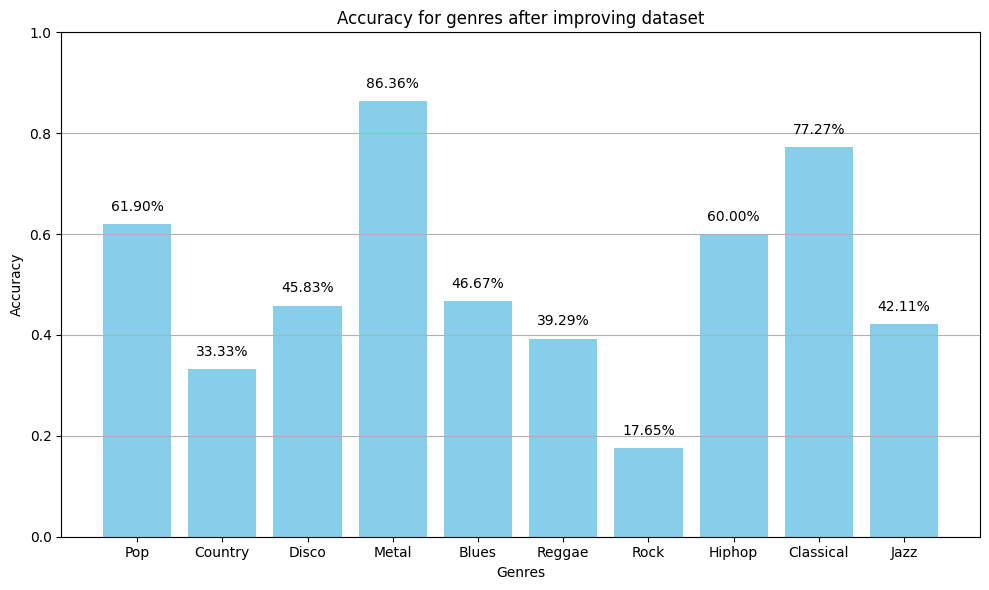

In [33]:
plt.figure(figsize=(10, 6))
plt.bar(genre_names, genre_accuracies, color='skyblue')
plt.title('Accuracy for genres before improving dataset')
plt.xlabel('Genres')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set ylim to 0-100%
plt.grid(axis='y')
for i, v in enumerate(genre_accuracies):
    plt.text(i, v + 0.02, f"{v*100:.2f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()